# Práctica 2: clasificación de dígitos MNIST mediante AdaBoost
---

## Introducción

En esta práctica se ha desarrollado un sistema para distinguir dígitos manuscritos del 0 al 9 en imagenes. El sistema implementado es de aprendizaje supervisado con AdaBoost. El objetivo de la práctica es entrenar al sistema, mediante un conjunto de imagenes de prueba, para clasificar imagenes en estas clases (dígitos del 0 al 9) aunque no hayan sido previamente analizadas por el sistema.

<img src="https://drive.google.com/uc?export=view&id=1CI-5CzMDSAiKRN8bE3MAniHjkVL3fDWn" width=500>

El banco de imagenes utilizado para las pruebas es la base de datos MNIST 

Lo primero será importar las librerías necesarias

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import random, math

Desde la libería de Keras podemos descargar la base datos MNIST

In [25]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape,y_train.shape

((60000, 28, 28), (60000,))

Podemos guardar la base de datos en un fichero con el siguiente comando

In [27]:
np.savez("mnist",x=x_train,y=y_train)

La cargamos para utilizarla

In [32]:
npzfile = np.load("mnist.npz")
mnist_X = npzfile['x']
mnist_Y = npzfile['y']
mnist_X.shape

(60000, 28, 28)

Veamos alguna de las imagenes del banco de datos

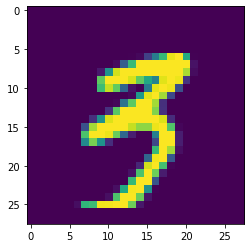

Etiqueta: 3


In [24]:
plt.figure()
plt.imshow(mnist_X[1007])
plt.show()
print("Etiqueta: " + str(mnist_Y[1007]))

### Implementación AdaBoost

Adaptación de los arrays de imágenes y etiquetas para AdaBoost en función de la clase para la que se va a entrenar

In [41]:
N_entr = 20000
N_test = 30000

def adaptar_conjuntos(mnist_X, mnist_Y, clase):
    X = mnist_X[:N_entr].reshape(N_entr, 784)

    Y = []
    for i in range(len(mnist_Y[:N_entr])):
        if mnist_Y[i] == clase:
            Y.append(1)
        else:
            Y.append(-1)
    
    return (X, Y)


def adaptar_conjuntos_test(mnist_X, mnist_Y):
    X = mnist_X.copy()
    X = np.reshape(X[N_entr:N_test], (N_test-N_entr, 784))

    return (X, mnist_Y)

Funciones necesarias para los clasificadores débiles

In [2]:
def generar_clasificador_debil(dimension_datos):
    return (random.randint(0, dimension_datos-1), random.randint(0, 255), random.choice((-1, 1)))

In [18]:
def aplicar_clasificador_debil(clasificador, imagen):
    v = imagen[:,clasificador[0]]
    return ((v >= clasificador[1]) * 1 + (v < clasificador[1]) * -1) * clasificador[2]

In [19]:
def obtener_error(clasificador, X, Y, D):
    return D * (aplicar_clasificador_debil(clasificador, X) != Y)

Función de entrenamiento adaboost que nos permite obtener un conjunto de clasificadores fuertes y sus respectivos valores $\alpha$.

In [34]:
def adaboost(X, Y, T, A):
    clasificadores_debiles = []
    alphas = []

    D = np.full(len(X), 1.0 / len(X))

    for t in range(T):
        conjuntos = []
        for k in range(A):
            c_d = generar_clasificador_debil(3)            # Obtenemos un clasificador debil
            clas = aplicar_clasificador_debil(c_d, X)      # Guardamos las clasificaciones de las imagenes
            eps = np.sum(obtener_error(c_d, X, Y, D))      # Calculamos el error 
            conjuntos.append((c_d, eps, clas))             # Almacenamos el conjunto con el formato (clasificador, error, resultados)
        pri = True
        for elem in conjuntos:
            if pri:
                fc = elem
                pri = False
                continue
            if elem[1] < fc[1]:           # Guardamos el conjunto con menor error
                fc = elem  
        alph = 0.5*math.log2((1-fc[1])/fc[1])   # Cálculo de alpha
        alphas.append(alph)
        clasificadores_debiles.append(fc[0])

        Z = np.sum(D)           #Actualizamos D
        for i in range(len(D)):
            D[i] = (D[i] * (math.e ** (-alph * Y[i] * fc[2][i])))/Z
        
    return (clasificadores_debiles, alphas)

Función para aplicar nuestro clasificador fuerte una vez se ha entrenado. Esta función nos permite obtener, para una imagen, el valor que tiene en una clase, según los clasificadores debiles de esta clase ponderados por su $\alpha$. 

In [35]:
def aplicar_clasificador_fuerte(clasificadores, alphas, imagen):
    clasificacion = 0
    for i in range(len(clasificadores)):
        clasificacion += alphas[i] * aplicar_clasificador_debil(clasificadores[i], np.array([imagen]))

    return clasificacion

Además se ha implementado una función que entrena el sistema para las 10 clases haciendo uso de la función adaboost

In [38]:
def entrenar_sistema(mnist_X, mnist_Y, T, A):
    clasificadores = []
    alphas = []
    print("Proceso de entrenamiento")
    for clase in range(10):
        print(f"Clasificador de la clase \"{clase}\" en proceso de entrenamiento")
        (trainX, trainY) = adaptar_conjuntos(mnist_X, mnist_Y, clase)
        (cl, al) = adaboost(trainX, trainY, T, A)
        clasificadores.append(cl)
        alphas.append(al)
    return (clasificadores, alphas)

Se ha implementado la siguiente función que permite probar para un set de imagenes, el índice de acierto que tiene el sistema para una clase.

In [48]:
def testn(X, Y, clasificadores, alphas, n):
    correct = total = 0

    for i in range(len(X)):
        if (Y[i] != n):
            continue
        total += 1
        clasif = (-1, 0)
        for j in range(10):
            punt = (aplicar_clasificador_fuerte(clasificadores[j], alphas[j], X[i]))
            if punt > clasif[1]:
                clasif = (j, punt)
        if n == clasif[0]: 
            correct += 1

    return correct/total

Vamos a realizar una prueba para la clase "0"

In [49]:
T = 10
A = 20
(clasificadores, alphas) = entrenar_sistema(mnist_X, mnist_Y, T, A)
(testX, testY) = adaptar_conjuntos_test(mnist_X, mnist_Y)
print(f"Índice de aciertos del sistema para clase 0: {testn(testX, testY, clasificadores, alphas, 8)}")

Proceso de entrenamiento
Clasificador de la clase "0" en proceso de entrenamiento
Clasificador de la clase "1" en proceso de entrenamiento
Clasificador de la clase "2" en proceso de entrenamiento
Clasificador de la clase "3" en proceso de entrenamiento
Clasificador de la clase "4" en proceso de entrenamiento
Clasificador de la clase "5" en proceso de entrenamiento
Clasificador de la clase "6" en proceso de entrenamiento
Clasificador de la clase "7" en proceso de entrenamiento
Clasificador de la clase "8" en proceso de entrenamiento
Clasificador de la clase "9" en proceso de entrenamiento
Índice de aciertos del sistema para clase 0: 0.0


Para realizar un análisis que ayude a determinar los valores adecuados para T y A se ha utilizado la siguiente función

In [ ]:
(imagenes_X, etiquetas_Y) = adaptar_conjuntos_t(mnist_X, mnist_Y, 2)

# Cuestiones sobre la práctica

## Explica brevemente cómo has adaptado la base datos MNIST al algoritmo AdaBoost

## Comenta detalladamente el funcionamiento de AdaBoost teniendo en cuenta que tasa media de fallos obtienes para aprendizaje y test. Correlaciona los porcentajes de acierto y de fallo con los valores de A y de T.

## ¿Cómo afecta el número de clasificadores generados al tiempo empleado para el proceso de aprendizaje? ¿Qué importancia le darías? Justifica tu respuesta. 

## ¿Cómo has dividido los datos en conjunto de entrenamiento y test? ¿Para qué es útil hacer esta división? 

## ¿Has observado si se produce sobre entrenamiento? Justifica tu respuesta con una gráfica en la que se compare el error de entrenamiento y el de test a lo largo de las ejecuciones. 

## ¿Cómo has conseguido que Adaboost clasifique entre los 10 dígitos cuando solo tiene una salida binaria?

## ¿Varía T y A entre ambos clasificadores débiles al usarlos en Adaboost? ¿Cuál requiere un T más elevado? ¿Porqué?

## ¿Qué clasificador débil crees que funciona mejor para clasificar un dígito? ¿Y el problema completo con 10 dígitos?